# 第八章 SQL高级处理

## 8-1 窗口函数
**窗口函数：**也称为OLAP函数，OLAP是*OnLine Analytical Processing*的简称，意即对数据库数据进行实时分析处理。例如，市场分析、创建财务报表、创建计划等日常性商务工作。窗口函数是为了实现OLAP而添加的标准SQL功能。（MySQL还不支持窗口函数）

### 1. 窗口函数的语法
**能够作为窗口函数使用的函数**
1. 能够作为窗口函数的聚合函数（SUM、AVG、COUNT、MAX、MIN)
2. RANK、DENSE_RANK、ROW_NUMBER等专用窗口函数
**语法 8-1 窗口函数**  
　　<窗口函数> OVER ( [PARTITION BY <列清单>]  
　　　　　　 　　　　ORDER BY  <排序专用清单> )  
1. PARTITION BY 能够设定排序的对象范围。
2. ORDER BY 能够指定按照哪一列、何种顺序进行排序。 

### 2. 语法的基本使用方法——使用RANK函数
**代码：**  
SELECT product_name, product_type, sale_price,  
　　RANK () OVER ( PARTITION BY product_type  
　　ORDER BY sale_price ) AS ranking  
　　FROM Product;  
*输出结果*
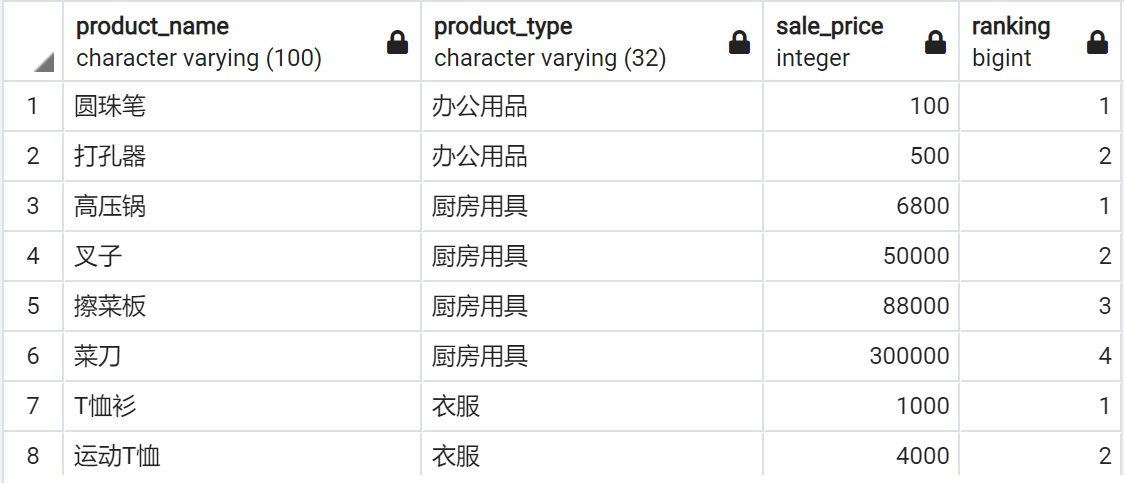  
*PARTITION BY和ORDER BY的作用*
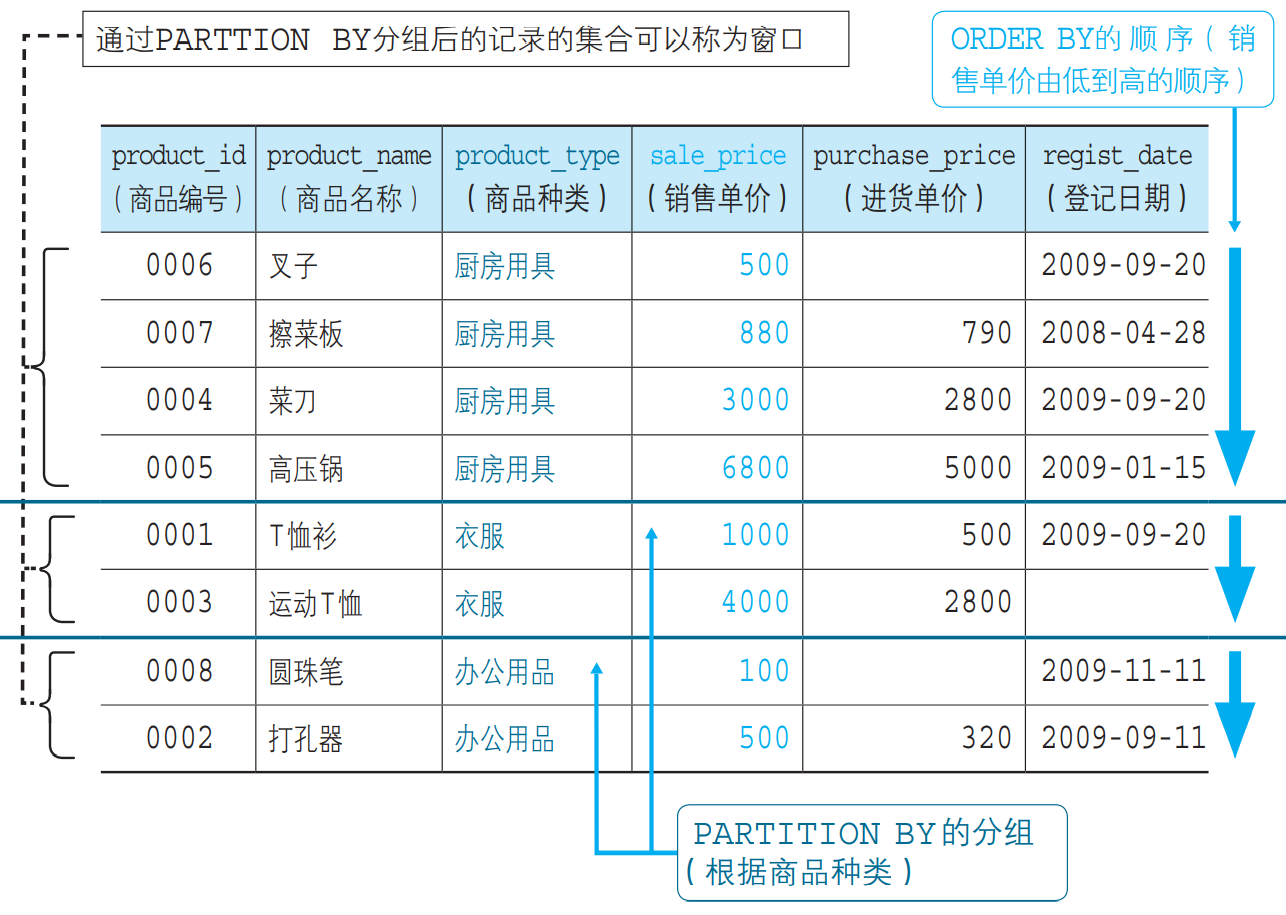

### 3.无需指定PARTITION BY
使用窗口函数时起到关键作用的是 PARTITION BY 和 GROUP BY。其中，PARTITION BY 并不是必需的，即使不指定也可以正常使用窗口函数。这和使用没有 GROUP BY 的聚合函数时的效果一样，也就是将整个表作为一个大的窗口来使用。

### 4.专用窗口函数的种类
* RANK函数
计算排序时，如果存在相同位次的记录，则会跳过之后的位次。
例）有 3 条记录排在第 1 位时：1 位、1 位、1 位、4 位……
* DENSE_RANK函数
同样是计算排序，即使存在相同位次的记录，也不会跳过之后的位次。
例）有 3 条记录排在第 1 位时：1 位、1 位、1 位、2 位……
* ROW_NUMBER函数
赋予唯一的连续位次。
例）有 3 条记录排在第 1 位时：1 位、2 位、3 位、4 位……

### 5.窗口函数的适用范围
原则上窗口函数只能在SELECT子句中使用（不能在WHERE子句或者GROUP BY子句中使用）  
在 DBMS 内部，窗口函数是对 WHERE 子句或者 GROUP BY 子句处理后的“结果”进行的操作。

### 6.作为窗口函数使用的聚合函数
* SUM作为窗口函数使用  
  **代码：**  
SELECT product_id, product_name, sale_price,  
　　SUM (sale_price) OVER ( ORDER BY product_id ) AS current_sum  
　　FROM Product;  
  使用 SUM 函数时，并不像 RANK 或者 ROW_NUMBER 那样括号中的内容为空，而是、需要在括号内指定作为汇总对象的列。本例中我们计算出了销售单价（sale_price）的合计值（current_sum）。但是我们得到的并不仅仅是合计值，而是按照 ORDER BY 子句指定的 product_id 的升序进行排列，计算出商品编号“小于自己”的商品的销售单价的合计值。  
　*输出结果*  
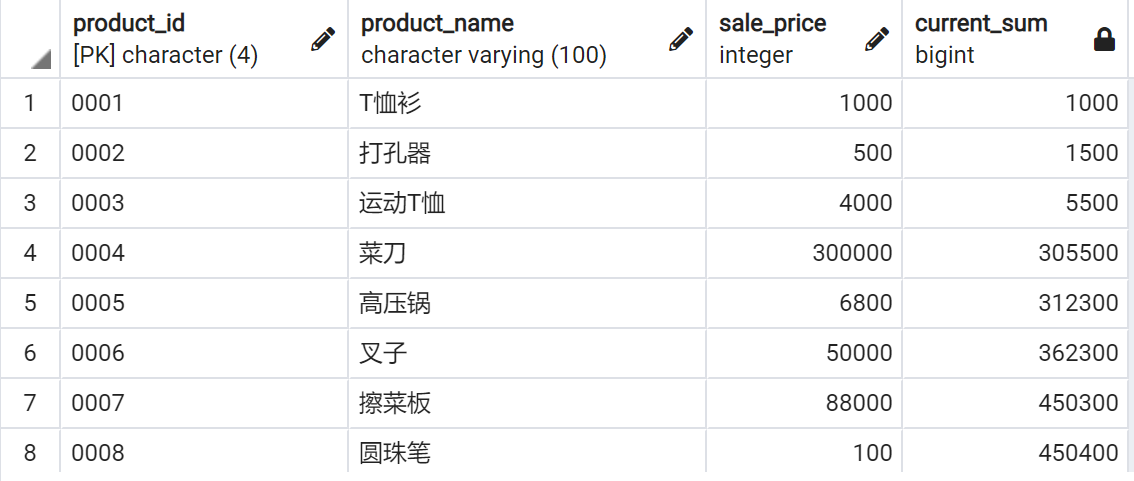
* AVG函数作为窗口函数使用  
  **代码：**  
  SELECT product_id, product_name, sale_price,  
　　AVG (sale_price) OVER ( ORDER BY product_id ) AS current_avg  
　　FROM Product;  
  类似于SUM函数，AVG函数计算“排在自己之上”的记录的平均值。  
  *输出结果*
  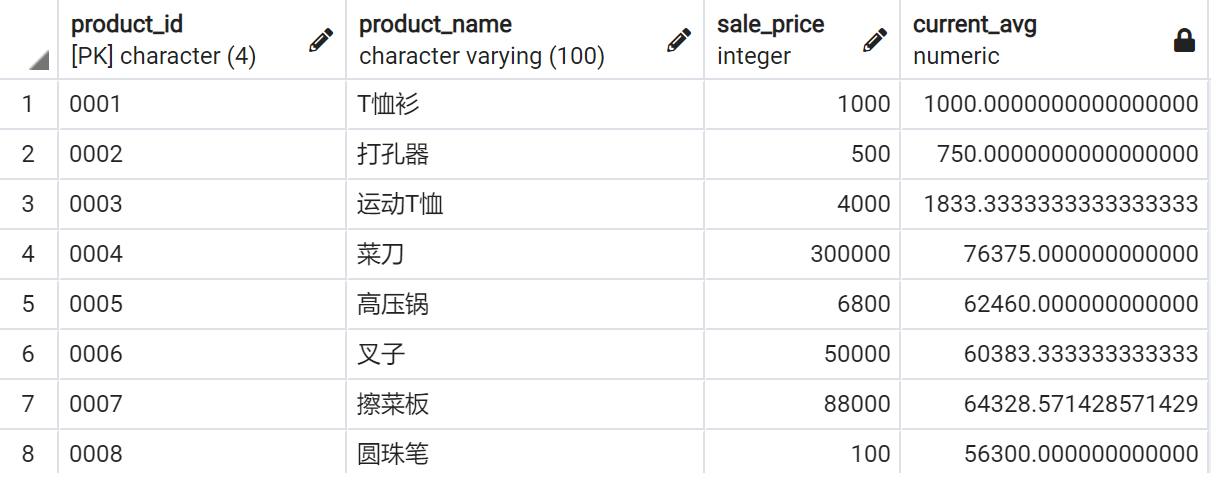

### 7.计算移动平均
窗口函数还包含在窗口中指定更加详细的汇总范围的备选功能，该备选功能中的汇总范围称为框架。  
**代码 指定“最靠近的3行”作为汇总对象**  
SELECT product_id, product_name, sale_price,  
　　AVG (sale_price) OVER ( ORDER BY product_id 
　　　　　　　　　　　　　ROWS 2 PRECEDING ) AS moving_avg  
　　FROM Product;  
*输出结果*
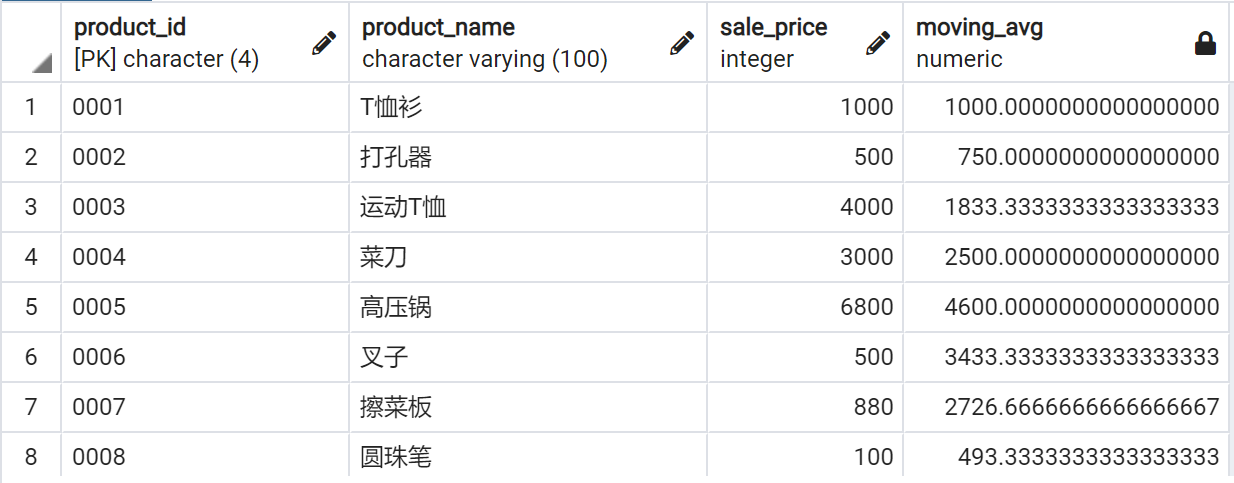  
这里我们使用了 ROWS（“行”）和 PRECEDING（“之前”）两个关键字，将框架指定为“截止到之前 ~ 行”，因此“ROWS 2 PRECEDING”就是将框架指定为“截止到之前 2 行”，也就是将作为汇总对象的记录限定为“最靠近的 3 行”。就是说，由于框架是根据当前记录来确定的，因此和固定的窗口不同，其范围会随着当前记录的变化而变化。  
使用关键字 FOLLOWING（“之后”）替换 PRECEDING，就可以指定“截止到之后 ~ 行”作为框架。  
如果希望将当前记录的前后行作为汇总对象时，可以同时使用 PRECEDING（“之前”）和 FOLLOWING（“之后”）关键字来实现。  
**代码 将当前记录的前后行作为汇总对象**  
SELECT product_id, product_name, sale_price,  
　　AVG (sale_price) OVER ( ORDER BY product_id  
　　　　　　　　　　　　　　　ROWS BETWEEN 1 PRECEDING  
　　　　　　　　　　　　　　　　　　　　AND 1 FOLLOWING) AS moving_avg  
　　FROM Product;  
*输出结果*  
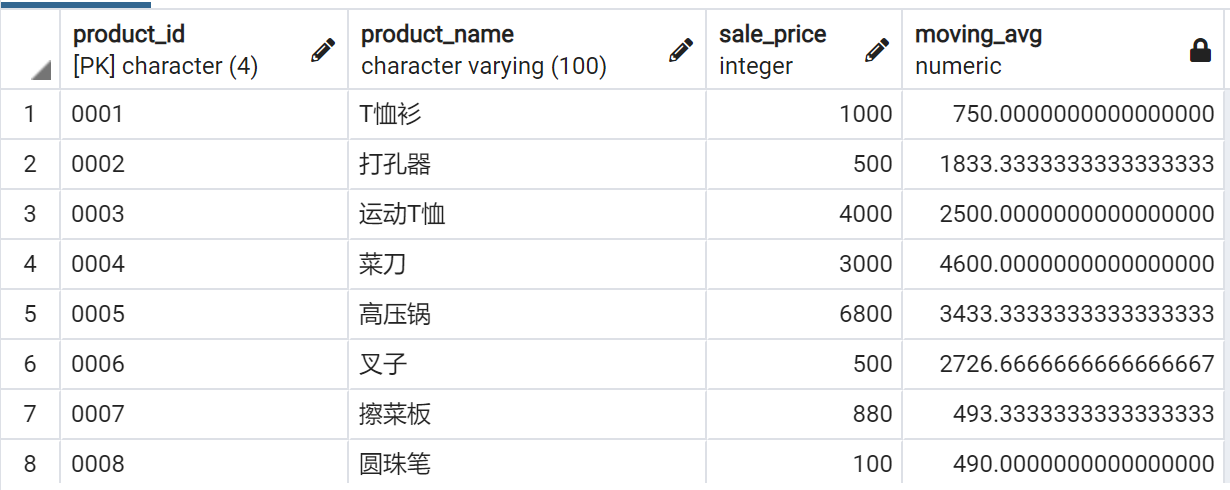

### 8.两个ORDER BY
* 注意：OVER 子句中的 ORDER BY 只是用来决定窗口函数按照什么样的顺序进行计算的，对结果的排列顺序并没有影响。最后结果的排列顺序可能是混乱的结果。在SELECT语句的最后，使用ORDER BY子句进行指定，就能保证SELETC语句的结果中记录的排列顺序。  
 **代码**  
 SELECT product_name, product_type, sale_price,  
 　　RANK () OVER (ORDER BY sale_price) AS ranking  
 　　FROM Product  
 　　ORDER BY ranking;  
 *输出结果*
 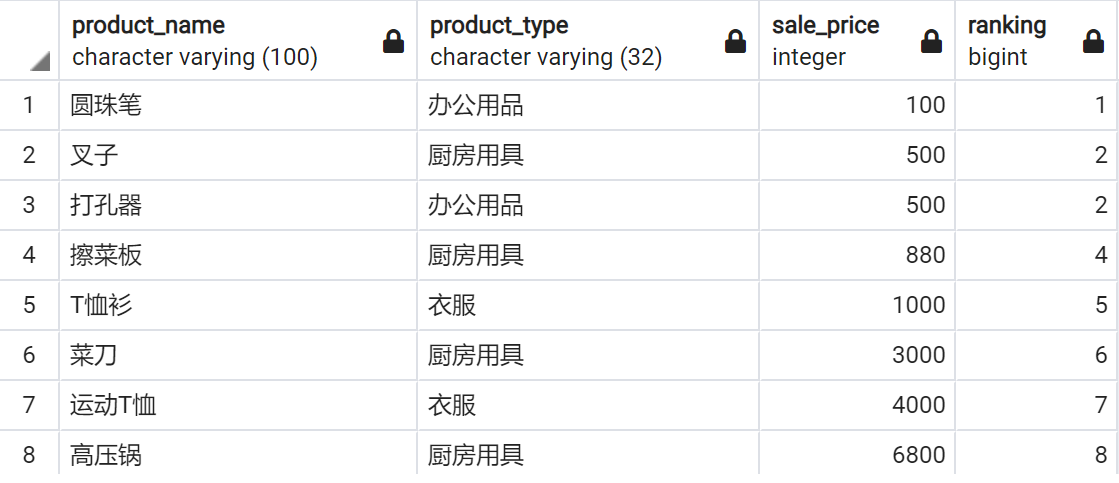

## 8.2 GROUPING运算符

### 1.同时得到合计行
只使用GROUP BY子句是无法得到如下表的结果，问题在于最上面多出了1行合计行。使用GROUP BY子句无法得到这一行，因为 GROUP BY 子句是用来指定聚合键的场所，所以只会根据这里指定的键分割数据，当然不会出现合计行。而合计行是不指定聚合键时得到的汇总结果。  
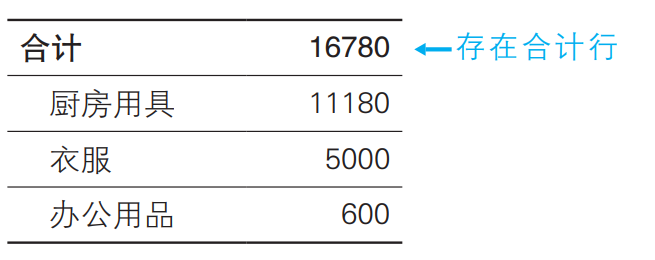
如果想要获得这样的结果，通常的做法是分别计算合计行和按照商品种类进行汇总的结果，然后通过UNION ALL连接在一起  
**代码**  
SELECT '合计' AS product_type,SUM(sale_price)  
　　FROM product  
UNION ALL  
SELECT product_type, SUM(sale_price)  
　　FROM product  
　　GROUP BY product_type;  
*输出结果*
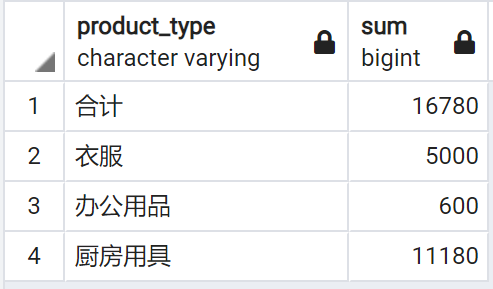

### 2.ROLLUP——同时得出合计行和小计
* GROUPING运算符包含以下3种：
    * ROLLUP
    * CUBE
    * GROUPING SETS
* ROLLUP的使用方法  
 **代码**  
 SELECT product_type, SUM(sale_price) AS sum_price  
  FROM Product  
  GROUP BY ROLLUP(product_type);  
 *输出结果*  
 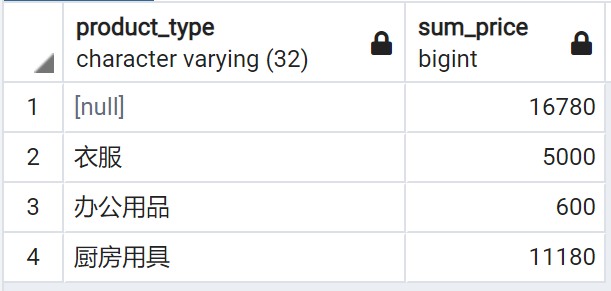
 从语法上来说，就是将 GROUP BY 子句中的聚合键清单像 ROLLUP（< 列 1>,< 列 2>,...）这样使用。该运算符的作用就是“一次计算出不同聚合键组合的结果”。例如，在本例中就是一次计算出了如下两种组合的汇总结果。
    * GROUP BY()
    * GROUP BY(product_type)
    
 GROUP BY () 表示没有聚合键，也就相当于没有 GROUP BY子句（这时会得到全部数据的合计行的记录），该合计行记录称为超级分组记录（super group row）。超级分组记录的 product_type列的键值（对 DBMS 来说）并不明确，因此会默认使用 NULL。
* 将“登记日期”添加到聚合键当中  
 **代码 在GROUP BY中添加“登记日期”（不使用ROLLUP）**  
 SELECT product_type, regist_date, SUM(sale_price) AS sum_price  
 FROM Product  
 GROUP BY product_type, regist_date  
 ORDER BY product_type
 *输出结果*
 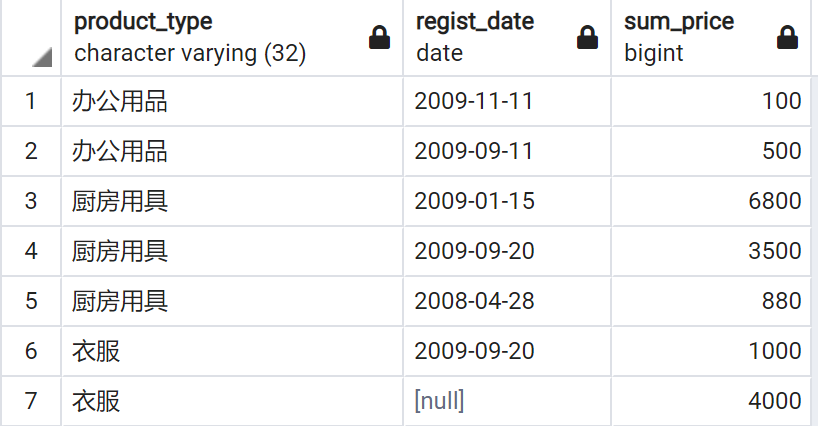
 **代码 在GROUP BY中添加“登记日期”（使用ROLLUP）**  
 SELECT product_type, regist_date, SUM(sale_price) AS sum_price  
 FROM Product  
 GROUP BY ROLLUP(product_type, regist_date)  
 ORDER BY product_type
 *输出结果*
 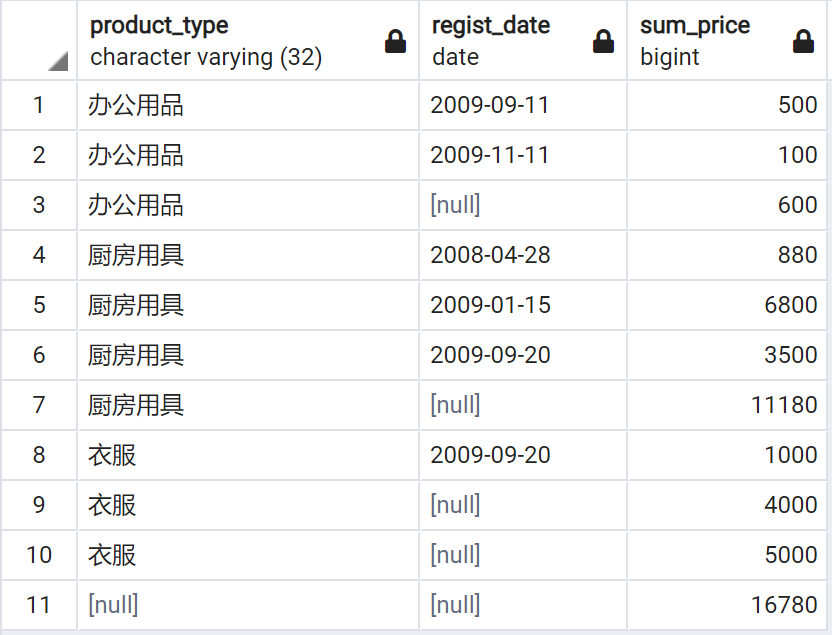
 将上述两个结果进行比较后我们发现，使用 ROLLUP 时多出了最上方的合计行以及 3 条不同商品种类的小计行（也就是未使用登记日期作为聚合键的记录），这 4 行就是我们所说的超级分组记录。也就是说，该SELECT 语句的结果相当于使用 UNION 对如下 3 种模式的聚合级的不同结果进行连接：
    * GROUP BY()
    * GROUP BY(product_type)
    * GROUP BY(product_type, regist_date)

### 3.GROUPING函数——让NULL更加容易分辨
* 为了避免混淆NULL,SQL 提供了一个用来判断超级分组记录的 NULL 的特定函数 —— GROUPING 函数。该函数在其参数列的值为超级分组记录所产生的 NULL 时返回1，其他情况返回0。  
 **代码**  
SELECT GROUPING(product_type) AS product_type,   
 GROUPING(regist_date) AS regist_date, SUM(sale_price) AS sum_price  
 FROM Product  
 GROUP BY ROLLUP(product_type, regist_date)  
 *输出结果*
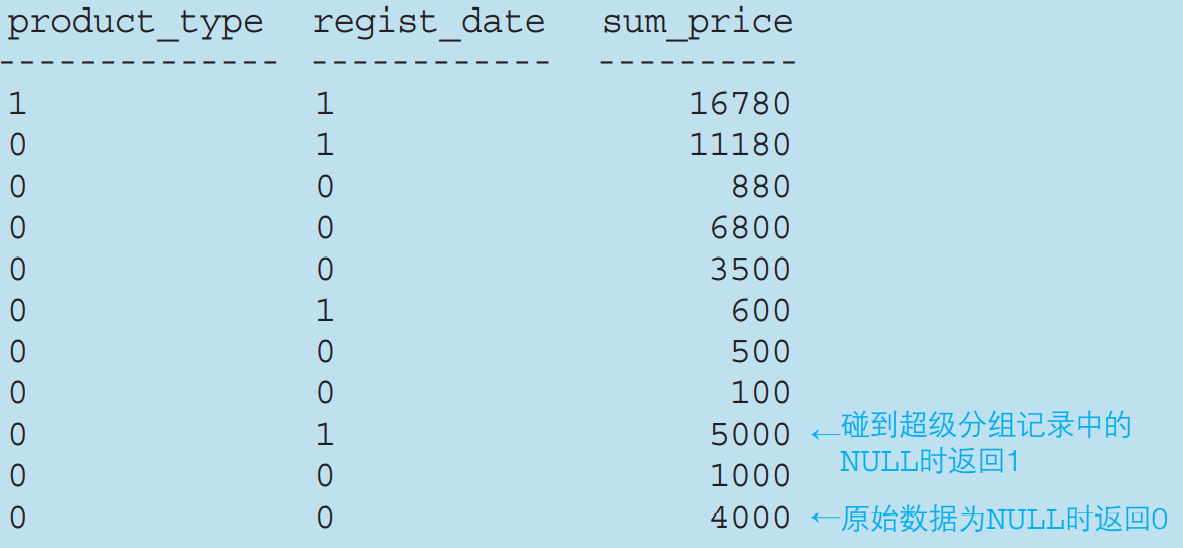
* 使用 GROUPING 函数还能在超级分组记录的键值中插入字符串。也就是说，当 GROUPING 函数的返回值为 1 时，指定“合计”或者“小计”等字符串，其他情况返回通常的列的值。  
 **代码**  
SELECT CASE WHEN GROUPING(product_type) = 1   
 THEN '商品种类 合计'   
 ELSE product_type END AS product_type,  
 CASE WHEN GROUPING(regist_date) = 1   
 THEN '登记日期 合计'  
 ELSE CAST(regist_date AS VARCHAR(16)) END AS regist_date,  
 SUM(sale_price) AS sum_price  
 FROM Product  
 GROUP BY ROLLUP(product_type, regist_date);  
 *输出结果*
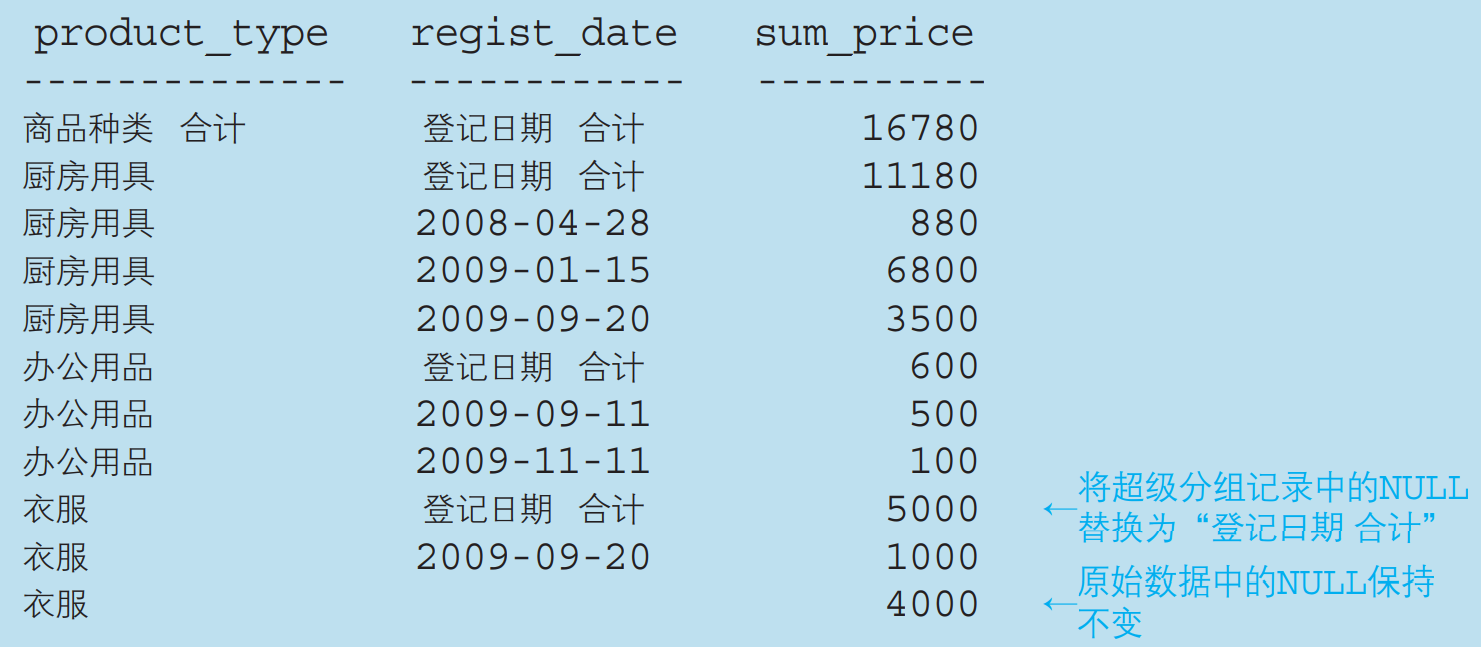
  
  
 CAST(regist_date AS VARCHAR(16))  
 是为了满足CASE 表达式所有分支的返回值必须一致的条件。如果不这样的话，那么各个分支会分别返回日期类型和字符串类型的值，执行时就会发生语法错误。

### 4.CUBE——用数据来搭积木
CUBE 的语法和 ROLLUP 相同，只需要将 ROLLUP 替换为 CUBE  
**代码**  
SELECT CASE WHEN GROUPING(product_type) = 1  
 THEN '商品种类 合计'  
 ELSE product_type END AS product_type,  
 CASE WHEN GROUPING(regist_date) = 1  
 THEN '登记日期 合计'  
 ELSE CAST(regist_date AS VARCHAR(16)) END AS regist_date,  
 SUM(sale_price) AS sum_price  
 FROM Product  
 GROUP BY CUBE(product_type, regist_date)  
*输出结果*
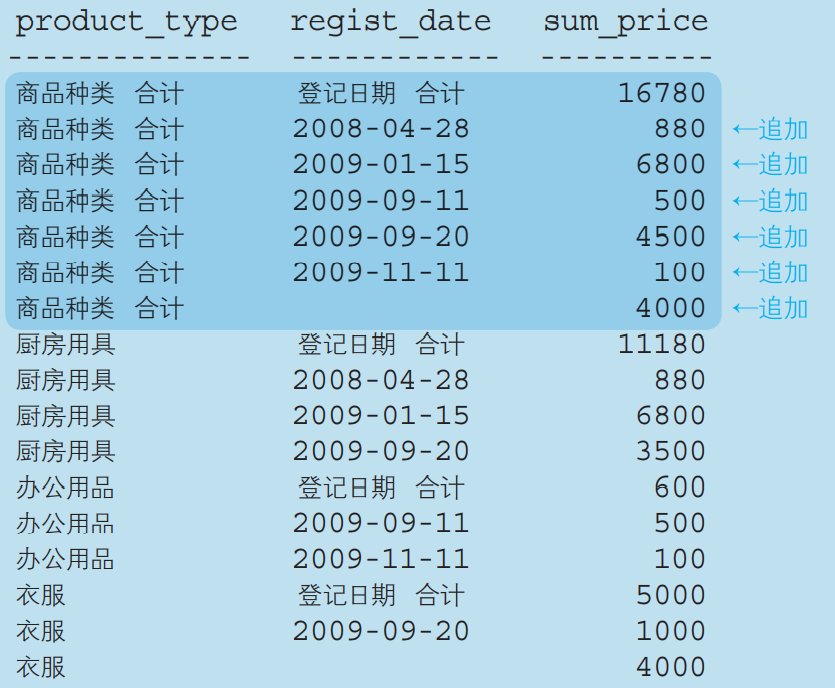
与 ROLLUP 的结果相比，CUBE 的结果中多出了几行记录。多出来的记录就是只把 regist_date 作为聚合键所得到的汇总结果。  
   * GROUP BY ()
   * GROUP BY (product_type)
   * GROUP BY (regist_date)
   * GROUP BY (product_type, regist_date)  
   
CUBE就是将 GROUP BY 子句中聚合键的“所有可能的组合”的汇总结果集中到一个结果中。因此，组合的个数就是$2^n$（n是聚合键的个数）。

### 4.GROUPING SETS
GROUPING SETS可以用于从 ROLLUP 或者 CUBE 的结果中取出部分记录。与 ROLLUP 或者CUBE 能够得到规定的结果相对，GROUPING SETS 用于从中取出个别条件对应的不固定的结果。  
例如，之前的 CUBE 的结果就是根据聚合键的所有可能的组合计算而来的。如果希望从中选取出将“商品种类”和“登记日期”各自作为聚合键的结果，或者不想得到“合计记录和使用 2 个聚合键的记录”时，可以使用 GROUPING SETS。  
**代码**  
SELECT CASE WHEN GROUPING(product_type) = 1  
 THEN '商品种类 合计'  
 ELSE product_type END AS product_type,  
 CASE WHEN GROUPING(regist_date) = 1   
 THEN '登记日期 合计'  
 ELSE CAST(regist_date AS VARCHAR(16)) END AS regist_date,  
 SUM(sale_price) AS sum_price  
 FROM Product  
 GROUP BY GROUPING SETS (product_type, regist_date)  
*输出结果*  
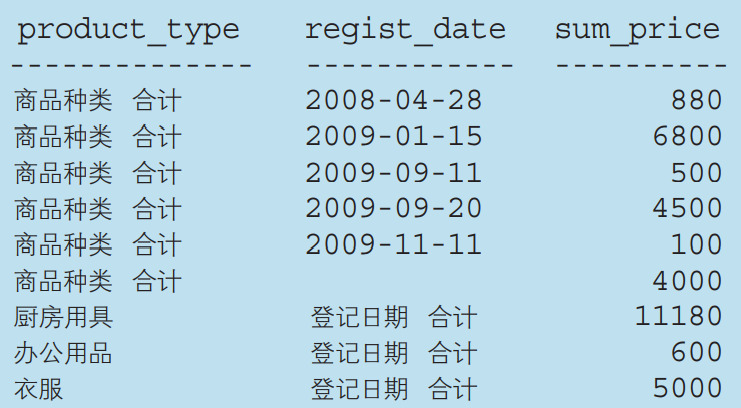